In [1]:
!pip install pyxlsb
!pip install pandas --upgrade
!pip install openpyxl

In [2]:
import pandas as pd
import pyxlsb
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from matplotlib.dates import DateFormatter

In [3]:
dataframe = pd.read_excel('stc TV Data Set_T2.xlsb', engine='openpyxl')

In [4]:
dataframe.head(10)

,Unnamed: 0,date_,Total_watch_time_in_houres
0,0,2018-01-01,1123.551944
1,1,2018-01-02,1000.129722
2,2,2018-01-03,881.924444
3,3,2018-01-04,782.669444
4,4,2018-01-05,1051.939444
5,5,2018-01-08,841.178333
6,6,2018-01-09,873.495000
7,7,2018-01-10,970.475000
8,8,2018-01-11,721.381944
9,9,2018-01-12,772.675000


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  86 non-null     int64         
 1   date_                       86 non-null     datetime64[ns]
 2   Total_watch_time_in_houres  86 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 KB


In [6]:
dataframe.describe()

,Unnamed: 0,date_,Total_watch_time_in_houres
count,86.000000,86,86.000000
mean,42.500000,2018-02-28 17:01:23.720930304,780.817926
min,0.000000,2018-01-01 00:00:00,562.124722
25%,21.250000,2018-01-30 06:00:00,707.709653
50%,42.500000,2018-02-28 12:00:00,763.181389
75%,63.750000,2018-03-29 18:00:00,840.985278
max,85.000000,2018-04-30 00:00:00,1123.551944
std,24.969982,NaN,122.992002


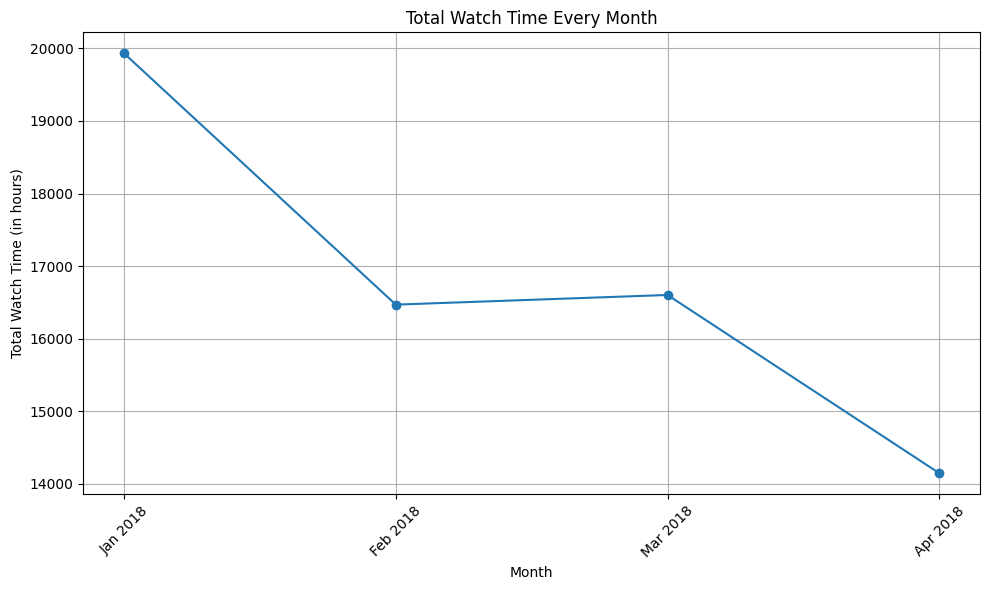

In [7]:
dataframe['date_'] = pd.to_datetime(dataframe['date_'])

# Group data by month and calculate total watch time for each month
monthly_data = dataframe.groupby(dataframe['date_'].dt.to_period('M'))['Total_watch_time_in_houres'].sum()
monthly_data.index = pd.to_datetime(monthly_data.index.to_timestamp())

monthly_data.index = monthly_data.index.strftime('%b %Y')

# Plot the data for each month (Total)
plt.figure(figsize=(10,6))
plt.plot(monthly_data.index, monthly_data.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Total Watch Time (in hours)')
plt.title('Total Watch Time Every Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

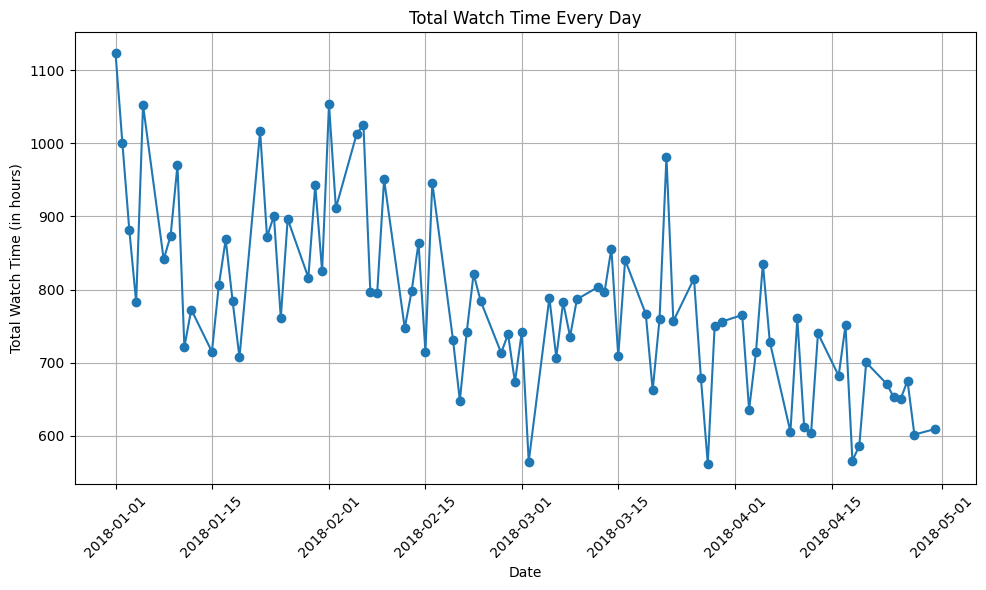

In [8]:
dataframe['date_'] = pd.to_datetime(dataframe['date_'])

# Plot the data for each day
plt.figure(figsize=(10, 6))
plt.plot(dataframe['date_'], dataframe['Total_watch_time_in_houres'], marker='o')
plt.xlabel('Date')
plt.ylabel('Total Watch Time (in hours)')
plt.title('Total Watch Time Every Day')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
p, d, q = 0, 1, 1
P, D, Q, m = 1, 1, 1, 12  # Set seasonal orders and m (assuming monthly data with yearly seasonality)

sarima_model = SARIMAX(dataframe['Total_watch_time_in_houres'], order=(p, d, q), seasonal_order=(P, D, Q, m))
fitted_model = sarima_model.fit()


next_day = fitted_model.forecast(steps=60)
print("Forecast for the next month:")
next_day_dates = pd.date_range(start='2018-05-01', periods=60)

Forecast for the next month:


In [10]:
next_day = pd.DataFrame(next_day)
next_day.rename(columns={'predicted_mean': 'Total_watch_time_in_houres'}, inplace=True)
next_day.reset_index(drop=True, inplace=True)
next_day['date_'] = next_day_dates
first_column = next_day.pop('Total_watch_time_in_houres')
next_day['Total_watch_time_in_houres'] = first_column
concatenated_df = pd.concat([dataframe, next_day], ignore_index=True)

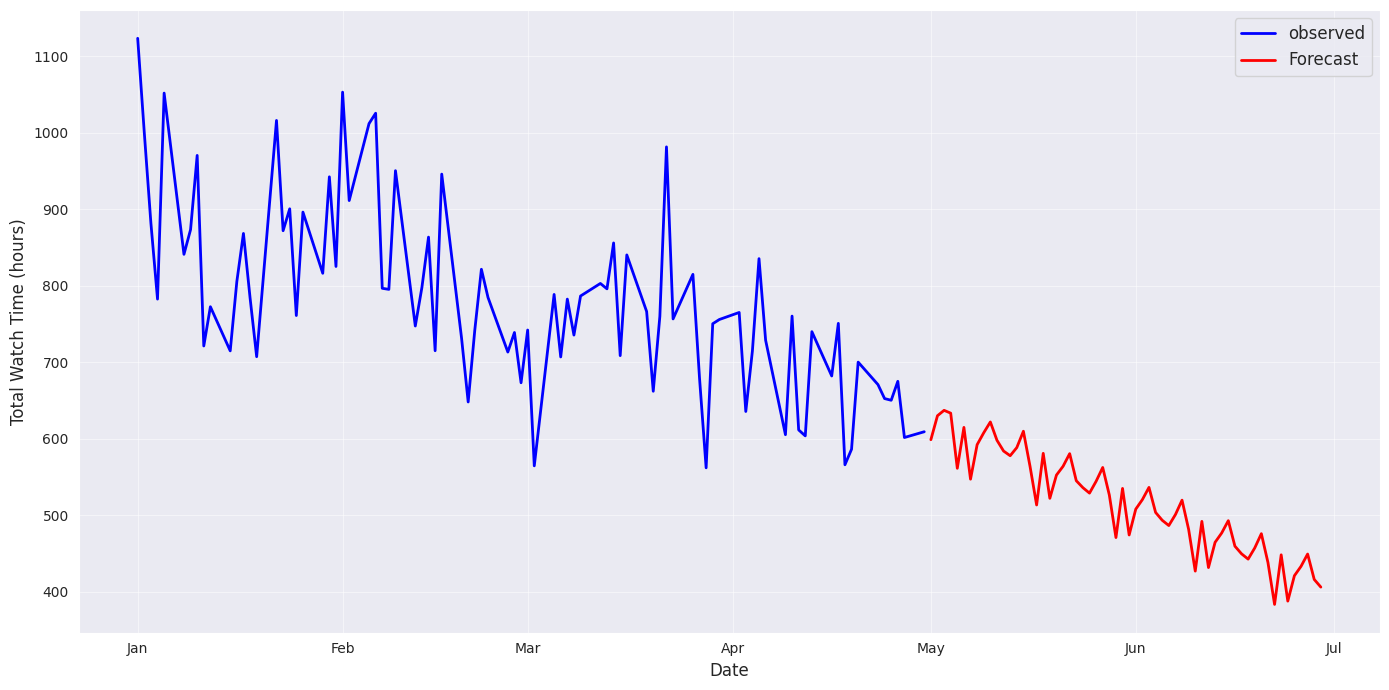

In [11]:
concatenated_df['date_'] = pd.to_datetime(concatenated_df['date_'])
sns.set_style('darkgrid')
plt.figure(figsize=(14, 7))
# Define a highlighted_mask (example: selecting data for a specific period)
highlighted_mask = (concatenated_df['date_'] >= '2023-08-01') & (concatenated_df['date_'] <= '2023-08-15')

# Plot the actual data before May 2018 in blue
plt.plot(concatenated_df[concatenated_df['date_'] < '2018-05']['date_'],
         concatenated_df[concatenated_df['date_'] < '2018-05']['Total_watch_time_in_houres'],
         label='observed', color='blue', linewidth=2)

# Plot the Forecast data after May 2018 in red
plt.plot(concatenated_df[concatenated_df['date_'] >= '2018-05']['date_'],
         concatenated_df[concatenated_df['date_'] >= '2018-05']['Total_watch_time_in_houres'],
         linewidth=2, color='red')


plt.plot(concatenated_df.loc[highlighted_mask, 'date_'],
         concatenated_df.loc[highlighted_mask, 'Total_watch_time_in_houres'],
         label='Forecast', color='red', linewidth=2)

date_form = DateFormatter("%b")
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Watch Time (hours)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()
